In [14]:
import os, random

import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from tqdm import tqdm

import matplotlib.pyplot as plt

import umap


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

from numpy.lib.stride_tricks import sliding_window_view
from skimage.feature import hog


In [15]:
def clusters_to_files(y, names):
    clusters = {}
    for i, name in enumerate(names):
        yi = int(y[i])
        if yi not in clusters:
            clusters[yi] = []
        clusters[yi].append(name)

    # text file:

    with open('clusters.txt', 'w') as f:
        for cluster in clusters:
            for name in clusters[cluster]:
                f.write(f"{name} ")
            f.write("\n")
    
    # html file:

    with open('clusters.html', 'w') as f:
        for cluster in clusters:
            for name in clusters[cluster]:
                f.write(f"<img src='training_samples/{name}'>")
            f.write("<HR>")



def center_image_by_centroid(img):
    img = img.astype(float)
    h, w = img.shape

    # Współrzędne pikseli
    y, x = np.indices((h, w))

    # Oblicz środek masy
    total = img.sum()
    if total == 0:
        return img.copy()
    
    cx = (x * img).sum() / total
    cy = (y * img).sum() / total

    # Gdzie powinien być środek
    target_cx = w // 2
    target_cy = h // 2

    # Potrzebne przesunięcie
    shift_x = int(round(target_cx - cx))
    shift_y = int(round(target_cy - cy))

    # Przesunięcie z użyciem np.roll
    shifted = np.roll(img, shift=shift_y, axis=0)
    shifted = np.roll(shifted, shift=shift_x, axis=1)

    # Wyzeruj artefakty po rollu (piksele owinięte z drugiej strony)
    if shift_y > 0:
        shifted[:shift_y, :] = 0
    elif shift_y < 0:
        shifted[shift_y:, :] = 0

    if shift_x > 0:
        shifted[:, :shift_x] = 0
    elif shift_x < 0:
        shifted[:, shift_x:] = 0

    return shifted

def smooth_imgs(img: np.ndarray) -> np.ndarray:
    if img.ndim != 2:
        raise ValueError("Funkcja obsługuje tylko 2D macierze")

    # Stworzenie kopii, aby nie nadpisać oryginału
    new_img = img.copy()

    # Operacja tylko na wewnętrznych pikselach
    new_img[1:-1, 1:-1] += 0.25 * (
        img[2:, 1:-1] +     # img[i+1][j]
        img[:-2, 1:-1] +    # img[i-1][j]
        img[1:-1, 2:] +     # img[i][j+1]
        img[1:-1, :-2]      # img[i][j-1]
    )

    return new_img

# I transform image into a 1d array
# I also add some features that I think can be very useful:
# - width
# - height
# - the number of pixels in the image
# - number of pixels with a certaing color (0, 255)
# I also scale the image and apply dimentionality redciton
def transform_image(image, max_x, max_y):
    pad_x = max_x - image.shape[0]
    pad_y = max_y - image.shape[1]
    # pad with white pixels (0)
    # add information about the number of pixels
    extra_features = np.array([
        image.shape[0],
        image.shape[1],
        image.shape[0] * image.shape[1],
    ], dtype=np.float32)

    image = np.pad(
        image,
        ((0, pad_x), (0, pad_y)),
        mode='constant',
        constant_values=0
    )

    image = center_image_by_centroid(image)
    image = smooth_imgs(image)

    return image.flatten(), extra_features

Wczytuję wszystkie training samples

In [16]:
images = []
image_names = []

for filename in os.listdir('./training_samples'):
    if filename.endswith('.png'):
        # Read the image file
        image_path = os.path.join('./training_samples', filename)
        image = Image.open(image_path).convert('L') # Convert to grayscale
        image = ImageOps.invert(image) # I want white pixels to be 0 and black pixels to be 255
        images.append(np.array(image))
        image_names.append(filename)


# samples = random.sample(range(len(images)), 2000)
# images, images_names = zip(*[(images[i], image_names[i]) for i in samples])

max_x = max(image.shape[0] for image in images)
max_y = max(image.shape[1] for image in images)

X_b, X_extra = [], []
for image in images:
    x, x_extra = transform_image(image, max_x, max_y)
    X_b.append(x)
    X_extra.append(x_extra)

Za dużo wymiarów. Może redukcja?

In [22]:
from sklearn.manifold import Isomap
from sklearn.preprocessing import PolynomialFeatures
from sklearn.manifold import LocallyLinearEmbedding


# For PCA we need to scale the data
scaler = StandardScaler()
X_b = scaler.fit_transform(X_b)


tr = umap.UMAP(
    n_components=25,
)

X_red = tr.fit_transform(X_b)


X_red = np.concatenate((X_red, X_extra), axis=1)

/home/jpniewski/studia/sus/sus1/pysus/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [23]:
def metric(X, k=3, squared=False):
    X = np.asarray(X, dtype=np.float32)
    
    core = X[:, :-k]
    last = X[:, -k:]
    
    X_sq = np.sum(core**2, axis=1)[:, None]
    D_sq = X_sq + X_sq.T - 2 * np.dot(core, core.T)
    np.maximum(D_sq, 0, out=D_sq)
    euclid = D_sq if squared else np.sqrt(D_sq)
    
    l = last[:, None, :]
    lj = last[None, :, :]
    
    r = np.square(np.maximum(l, lj) / np.minimum(l, lj))
    R = np.prod(r, axis=2)
    
    return euclid + R

100%|██████████| 70/70 [01:20<00:00,  1.15s/it]

Best silhouette score:  0.3784539
Best number of clusters:  31


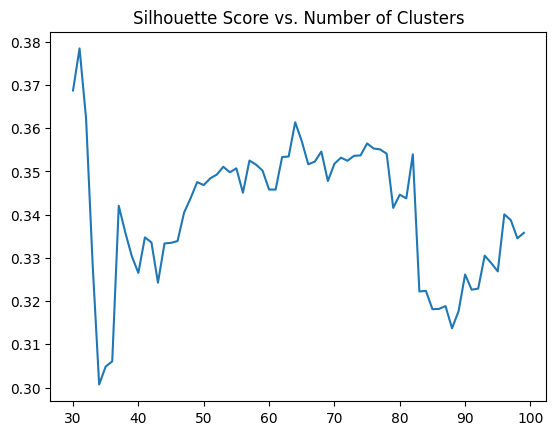

In [24]:
mi, mx = 30, 100

inertias = []
silhouette_scores = []

linkages = ['ward', 'complete', 'average', 'single']

D = metric(X_red)

for i in tqdm(range(mi, mx)):
    ag = AgglomerativeClustering(
        n_clusters=i, 
        linkage='average', 
        metric='precomputed'
    )

    y = ag.fit_predict(D)
    silhouette_scores.append(silhouette_score(X_red, y))    

print("Best silhouette score: ", max(silhouette_scores))
print("Best number of clusters: ", silhouette_scores.index(max(silhouette_scores)) + mi)

plt.plot(range(mi, mx), silhouette_scores)
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

ag = AgglomerativeClustering(
    n_clusters=np.argmax(silhouette_scores) + mi,
    linkage='average',
    metric='precomputed'
)
y = ag.fit_predict(D)
clusters_to_files(y, image_names)

In [20]:
clusters_to_files(y, image_names)

In [21]:
from sklearn.cluster import SpectralClustering

silhouette_scores = []

for i in tqdm(range(80, 81)):
    sc = SpectralClustering(
        n_clusters=i,
        affinity='precomputed',
        assign_labels='discretize',

    )

    y = sc.fit_predict(D)
    silhouette_scores.append(silhouette_score(X_red, y))

print("Best silhouette score: ", max(silhouette_scores))
print("Best number of clusters: ", silhouette_scores.index(max(silhouette_scores)) + 80)
plt.plot(range(80, 81), silhouette_scores)
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

  0%|          | 0/1 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
clusters_to_files(y, image_names)

In [ ]:
inertias = []
silhouette_scores = []

for i in tqdm(range(30, 80)):
    km = KMeans(n_clusters=i)
    km.fit(X_red)
    inertias.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_red, km.labels_))

plt.plot(range(30, 80), silhouette_scores)
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

print(f"Najlepsza liczba klastrów to {np.argmax(silhouette_scores) + 30} z wynikiem {max(silhouette_scores)}")

km = KMeans(n_clusters=np.argmax(silhouette_scores) + 30)
km.fit(X_red)
clusters = km.labels_
clusters_to_files(clusters, image_names)

No dobra spróbujmy znaleźć jakąś klasteryzację.

TODO: żeby sprawdzac poprawnosc tego gowna przyda sie pewnie zrobic jakis weryfikator ygh ygh.

In [ ]:
plt.plot(range(10, 100), silhouette_scores)
plt.title('Silhouette Score vs. Number of Clusters')
print(f"Najlepsza liczba klastrów to {np.argmax(silhouette_scores) + 10} z wynikiem {max(silhouette_scores)}")

In [ ]:
ag = AgglomerativeClustering(n_clusters=np.argmax(silhouette_scores) + 10, linkage=linkages[0])
ag.fit(X_red)
clusters = ag.labels_
clusters_to_files(clusters, image_names)

In [ ]:
silhouette_scores = []
num_clusters = []

l = 0

for i in tqdm(np.arange(0.1, 10, 0.1)):
    l += 1
    dbs = DBSCAN(eps=i, min_samples=1)
    y = dbs.fit_predict(X_red)
    silhouette_scores.append(silhouette_score(X_red, y))
    num_clusters.append(len(set(y)))

In [ ]:
print(l)
plt.plot(range(0, l), silhouette_scores)
plt.title('Silhouette Score vs. min_samples')
print(f"Najlepsza liczba klastrów to {num_clusters[np.argmax(silhouette_scores)]} z wynikiem {max(silhouette_scores)}")

In [ ]:
import torch

class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.SiLU(),

            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SiLU()
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_size, input_size),
            torch.nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    @torch.no_grad()
    def encode(self, x):
        x = self.encoder(x)
        return x


In [ ]:
X_tensor = torch.tensor(np.vstack(X), dtype=torch.float32)


In [ ]:
model = AutoEncoder(input_size=X_tensor.shape[1], hidden_size=20)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
epochs = 100

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = loss_fn(output, X_tensor)
    loss.backward()
    optimizer.step()

print(loss.item())

In [ ]:
X_red = model.encode(X_tensor).detach().numpy()

In [ ]:
X_red

In [ ]:
# max_x, max_y = 100, 40
def parse_img(filename):
    image = Image.open(filename).convert('L')
    image = np.array(ImageOps.invert(image)) # I want white pixels to be 0 and black pixels to be 255
    image = np.pad(
        image,
        ((0, max_x - image.shape[0]), (0, max_y - image.shape[1])),
        mode='constant',
        constant_values=0
    )
    return image.flatten().astype(np.float32)
        
    



# Będę nakładał x1 na x2 (trochę jak sliding window) 
# i liczył w kazdym punkcie abs(x1_ij - x2_ij).
# Wynik to minimalna odległość pomiędzy x1 i x2.
def metric(x1, x2, swp=False):
    # x1 = x1.reshape(max_x, max_y)
    # x2 = x2.reshape(max_x, max_y)
    # dist = np.float32(1000000000)
    # for i in range(10):
    #     for j in range(10):
    #         shifted = np.zeros_like(x1)
    # shifted[i:, j:] = x1[:max_x - i, :max_y - j]
    d = np.sum(np.square(x1 - x2)) / np.sum(np.maximum(x1, x2))
    # dist = np.min([dist, d])
    
    # if swp:
    return d
    # else:
    #     return min(dist, metric(x2, x1, True))
    
def Metric(X):
    n, _ = X.shape
    dist = np.zeros((n, n), dtype=np.float32)
    for i in tqdm(range(n)):
        for j in range(i + 1, n):
            dist[i, j] = metric(X[i], X[j])
            dist[j, i] = dist[i, j]
    return dist

In [ ]:
import random

X = [
    parse_img('./training_samples/' + filename)
    for filename in os.listdir('./training_samples')
]

sample = random.sample(list(zip(X, image_names)), 2000)
X_s, names_s = zip(*sample)


ag = AgglomerativeClustering(n_clusters=100, metric=Metric, linkage='average')
ag.fit(X_s)

print("Silhouette score:", silhouette_score(X_s, ag.labels_))
clusters = ag.labels_
clusters_to_files(clusters, names_s)